In [1]:
# importing libraries

import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

In [2]:
# defining base directory

BASE_DIR = r'C:\Users\rishi\Project'

# use os.path.join to build safety path

analysis_path = os.path.join(BASE_DIR, 'clean_analysis.csv')
ab_path = os.path.join(BASE_DIR, 'ab.csv')

# create dataframe

df = pd.read_csv(analysis_path)
df_ab = pd.read_csv(ab_path)

In [3]:
# Dataframe verification

df.shape

(75982, 21)

In [4]:
# Exploring data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75982 entries, 0 to 75981
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                75982 non-null  int64  
 1   product_id              75982 non-null  int64  
 2   customer_id             75982 non-null  int64  
 3   quantity                75982 non-null  int64  
 4   cost_price              75982 non-null  float64
 5   item_price              75982 non-null  float64
 6   discount_amount         75982 non-null  float64
 7   discount_pct            75982 non-null  float64
 8   shipping_fee            75982 non-null  float64
 9   shipping_fee_allocated  75982 non-null  float64
 10  product_revenue         75982 non-null  float64
 11  product_cost            75982 non-null  float64
 12  base_margin             75982 non-null  float64
 13  base_margin_pct         75982 non-null  float64
 14  final_margin            75982 non-null

In [5]:
df.head()

,order_id,product_id,customer_id,quantity,cost_price,item_price,discount_amount,discount_pct,shipping_fee,shipping_fee_allocated,...,product_cost,base_margin,base_margin_pct,final_margin,final_margin_pct,order_date,order_status,category,margin_flag,loss_driver
0,1,137,2829,1,2772.47,891.10,57.51,0.064538,30.08,15.040,...,2772.47,-1881.37,-2.111289,-1953.920,-2.192706,2024-09-03,Completed,Beauty,Negative Margin,Pricing / Cost Issue
1,1,273,2829,1,2206.41,3955.76,57.51,0.014538,30.08,15.040,...,2206.41,1749.35,0.442229,1676.800,0.423888,2024-09-03,Completed,Beauty,Healthy,Normal
2,2,154,2251,3,2301.69,3659.85,673.74,0.061363,171.59,85.795,...,6905.07,4074.48,0.371097,3314.945,0.301920,2024-06-11,Completed,Fashion,Healthy,Normal
3,2,255,2251,1,464.73,2540.87,673.74,0.265161,171.59,85.795,...,464.73,2076.14,0.817098,1316.605,0.518171,2024-06-11,Completed,Home,Healthy,Normal
4,3,176,11437,3,2559.93,3649.50,337.78,0.030852,31.42,15.710,...,7679.79,3268.71,0.298553,2915.220,0.266267,2024-02-29,Completed,Home,Healthy,Normal


In [6]:
# 1. Why is margin declining?

# This Process is done in 6 steps

# 1. Confirm the decline is real
# 2. Decompass margin into its parts (product revenue, product cost, Discount, Shipping)
# 3. compare before and after ( margin healthy vs margin worse -> avg discount %, avg shipping cost, base margin)
# 4. Segment the data ( category, discount band, loss driver, customer segment, shipping intensity)
# 5. Look for mix shift ( product got worse but because 'reason' and did the share of low-margin increase)
# 6. Connect the whole story ( margin declined primarily because of x, amplified by Y, WHILE Z remained stable)

In [7]:
# some important fixes used in further analysis

df['discount_pct'] = df['discount_pct'] * 100.0
df['base_margin_pct'] = df['base_margin_pct'] * 100.0
df['final_margin_pct'] = df['final_margin_pct'] * 100.0
df['order_date'] = pd.to_datetime(df['order_date'])

In [8]:
#1. confirm the decline is real ?

df['month'] = df['order_date'].dt.to_period('M')

monthly_data = (
    df.groupby('month')
      .agg(
          revenue=('product_revenue', 'sum'),
          profit=('final_margin', 'sum'),
          avg_margin_pct=('final_margin_pct', 'mean')
      )
      .reset_index()
)

monthly_data['overall_margin_pct'] = (
    monthly_data['profit'] / monthly_data['revenue']
) * 100



In [9]:
monthly_data

,month,revenue,profit,avg_margin_pct,overall_margin_pct
0,2023-01,21871944.61,9675465.52,11.749962,44.236878
1,2023-02,18460766.27,8125633.73,10.403704,44.015690
2,2023-03,21717977.93,9835970.03,12.667696,45.289530
3,2023-04,19843041.00,8367501.30,4.570086,42.168442
4,2023-05,22224992.22,9873002.17,9.289090,44.422972
5,2023-06,20933449.57,9156072.03,10.789972,43.738955
6,2023-07,21800887.20,9817416.42,11.801836,45.032188
7,2023-08,20934012.72,9346074.55,11.743381,44.645404
8,2023-09,21215824.95,9311961.14,11.319328,43.891582
9,2023-10,21147318.32,9214261.19,8.283065,43.571771


In [10]:
monthly_data.head()

,month,revenue,profit,avg_margin_pct,overall_margin_pct
0,2023-01,21871944.61,9675465.52,11.749962,44.236878
1,2023-02,18460766.27,8125633.73,10.403704,44.015690
2,2023-03,21717977.93,9835970.03,12.667696,45.289530
3,2023-04,19843041.00,8367501.30,4.570086,42.168442
4,2023-05,22224992.22,9873002.17,9.289090,44.422972


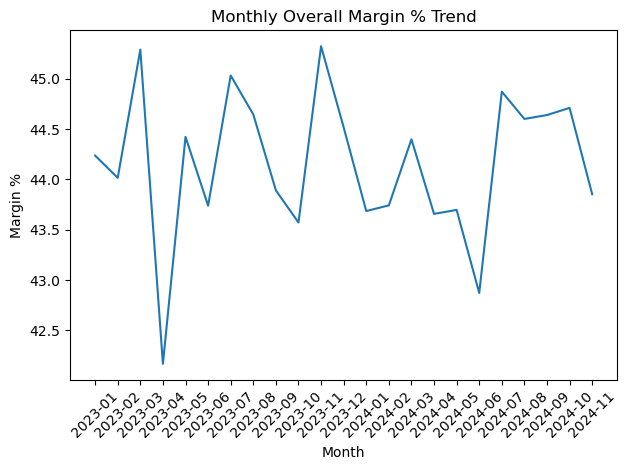

In [11]:
plt.figure()
plt.plot(
    monthly_data['month'].astype(str),
    monthly_data['overall_margin_pct']
)
plt.title('Monthly Overall Margin % Trend')
plt.xlabel('Month')
plt.ylabel('Margin %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Observation

# Overall margin remains broadly stable with recurring dips, indicating episodic margin pressure rather than a permanent structural decline.

In [35]:
# 2. Decompass margin into its parts (product revenue, product cost, Discount, Shipping)

margin_components = (
    df.groupby('month')
      .agg(
          revenue=('product_revenue', 'sum'),
          product_cost=('product_cost', 'sum'),
          discount=('discount_amount', 'sum'),
          shipping=('shipping_fee_allocated', 'sum'),
          final_margin=('final_margin', 'sum')
      )
      .reset_index()
)


margin_components


,month,revenue,product_cost,discount,shipping,final_margin
0,2023-01,21871944.61,10980996.19,1038022.85,176543.75,9675465.52
1,2023-02,18460766.27,9281541.25,903060.65,149001.24,8125633.73
2,2023-03,21717977.93,10687027.06,1025593.16,167553.94,9835970.03
3,2023-04,19843041.00,10357942.75,955678.27,158829.01,8367501.30
4,2023-05,22224992.22,11118071.39,1057736.59,173004.37,9873002.17
5,2023-06,20933449.57,10600090.91,1009915.24,166850.35,9156072.03
6,2023-07,21800887.20,10808990.56,1003526.31,167987.62,9817416.42
7,2023-08,20934012.72,10441342.41,986024.55,158693.15,9346074.55
8,2023-09,21215824.95,10709603.68,1025325.45,167556.87,9311961.14
9,2023-10,21147318.32,10761228.26,995560.09,172927.89,9214261.19


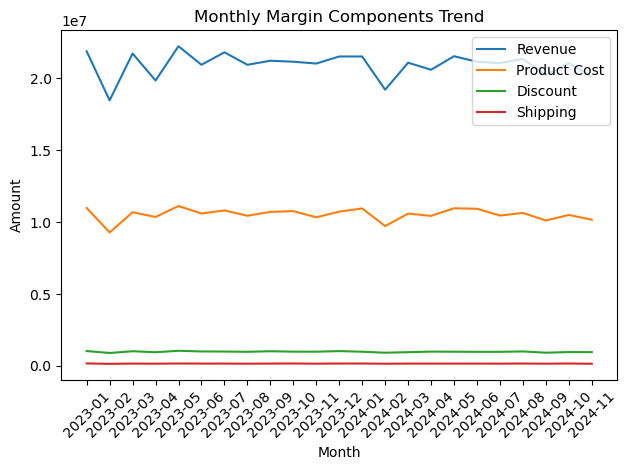

In [18]:
plt.figure()

plt.plot(
    monthly_components['month'].astype(str),
    monthly_components['revenue'],
    label='Revenue'
)

plt.plot(
    monthly_components['month'].astype(str),
    monthly_components['product_cost'],
    label='Product Cost'
)

plt.plot(
    monthly_components['month'].astype(str),
    monthly_components['discount'],
    label='Discount'
)

plt.plot(
    monthly_components['month'].astype(str),
    monthly_components['shipping'],
    label='Shipping'
)

plt.title('Monthly Margin Components Trend')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# observation

# “The margin decline is not driven by revenue contraction or product cost inflation. 
# Revenue and product costs remain largely stable over time. The primary pressure comes from sustained discounting, 
# with shipping acting as a secondary amplifier rather than a root cause.”

In [19]:
# 3. is margin sensitive to discount

df["discount_band"] = pd.cut(
    df["discount_pct"],
    bins=[-0.001, 0, 0.10, 0.30, 1],
    labels=["No Discount", "Low", "Medium", "High"]
)

discount_impact = (
    df.groupby("discount_band")
      .agg(
          avg_margin_pct=("final_margin_pct", "mean"),
          total_margin=("final_margin", "sum"),
          revenue=("product_revenue", "sum")
      )
      .reset_index()
)

discount_impact



C:\Users\rishi\AppData\Local\Temp\ipykernel_10564\636746323.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("discount_band")


,discount_band,avg_margin_pct,total_margin,revenue
0,No Discount,NaN,0.000000e+00,0.00
1,Low,50.242758,6.371331e+06,10629229.96
2,Medium,49.442809,1.264859e+07,21221776.67
3,High,47.734043,4.364186e+07,73564524.60


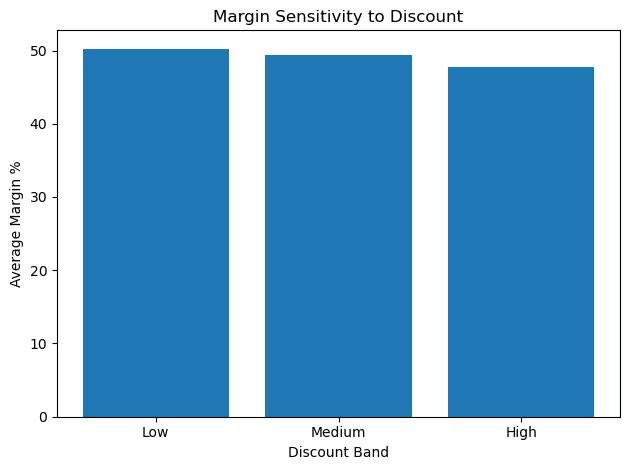

In [20]:
plt.figure()
plt.bar(
    discount_impact['discount_band'],
    discount_impact['avg_margin_pct']
)

plt.title('Margin Sensitivity to Discount')
plt.xlabel('Discount Band')
plt.ylabel('Average Margin %')
plt.tight_layout()
plt.show()

In [24]:
# Observation

# “Average margin percentage declines consistently as discount levels increase, confirming that margin is highly sensitive to discounting.
# Given that high-discount orders also represent the largest share of revenue, discounting is a material driver of margin pressure.”

In [22]:
category_health = (
    df
    .groupby("category")
    .agg(
        avg_margin_pct=("final_margin_pct", "mean"),
        loss_rate=("final_margin", lambda x: (x < 0).mean()),
        revenue=("product_revenue", "sum")
    )
    .reset_index()
    .sort_values("avg_margin_pct")
)

category_health

,category,avg_margin_pct,loss_rate,revenue
0,Beauty,0.001920,0.287015,1.411077e+08
3,Home,1.281585,0.274311,1.128822e+08
2,Fashion,19.188154,0.255919,1.154876e+08
1,Electronics,23.431795,0.238037,1.120257e+08


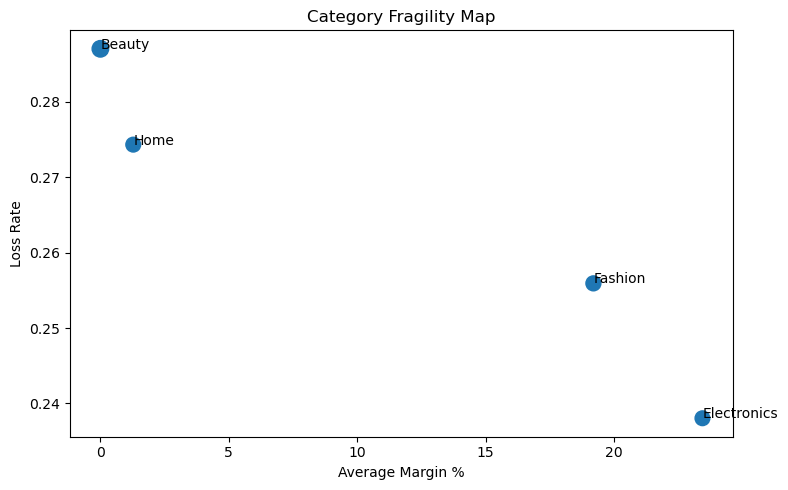

In [26]:
plt.figure(figsize=(8, 5))

plt.scatter(
    category_health['avg_margin_pct'],
    category_health['loss_rate'],
    s=category_health['revenue'] / 1e6
)

for x, y, label in zip(
    category_health['avg_margin_pct'],
    category_health['loss_rate'],
    category_health['category']
):
    plt.text(x, y, label)

plt.xlabel('Average Margin %')
plt.ylabel('Loss Rate')
plt.title('Category Fragility Map')
plt.tight_layout()
plt.show()

In [28]:
#observation

# Category fragility is concentrated in Beauty and Home, driven by weak margin efficiency and high loss frequency,
# while Electronics remains structurally healthy and Fashion shows moderate but manageable risk.

In [30]:
# 5.Is there a mix-shift toward low-margin orders?

df['month'] = df['order_date'].dt.to_period('M')

df['low_margin'] = df['margin_flag'].isin(['Low Margin', 'Negative Margin'])

order_mix = (
    df.groupby('month')['low_margin']
      .mean()
      .reset_index(name='low_margin_order_share')
)

order_mix

,month,low_margin_order_share
0,2023-01,0.287988
1,2023-02,0.293958
2,2023-03,0.291236
3,2023-04,0.319578
4,2023-05,0.293005
5,2023-06,0.296884
6,2023-07,0.291865
7,2023-08,0.294458
8,2023-09,0.299701
9,2023-10,0.305704


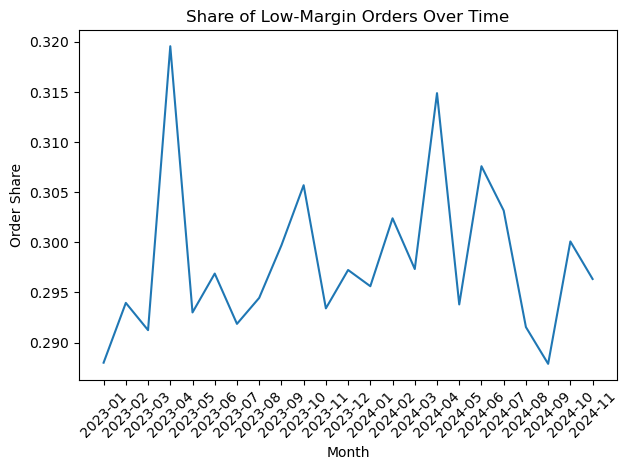

In [31]:
plt.figure()
plt.plot(order_mix['month'].astype(str), order_mix['low_margin_order_share'])
plt.title('Share of Low-Margin Orders Over Time')
plt.xlabel('Month')
plt.ylabel('Order Share')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# Observation

# A consistently high proportion of low-margin orders (~30%) indicates a structural mix shift toward lower-quality profitability,
# contributing to sustained margin pressure rather than a short-term fluctuation.

In [12]:
# 6.Which loss drivers hurt the most?

loss_driver_impact = (
    df[df["final_margin"] < 0]
      .groupby("loss_driver")
      .agg(
          total_loss=("final_margin", "sum"),
          loss_orders=("order_id", "nunique")
      )
      .sort_values("total_loss")
)

loss_driver_impact


,total_loss,loss_orders
loss_driver,,
Pricing / Cost Issue,-3.291334e+07,13241
Return-Driven,-3.251183e+06,1492
Multi-Factor Loss,-5.401162e+05,2113
Discount-Driven,-2.114214e+05,734
Shipping-Driven,-1.497853e+04,160


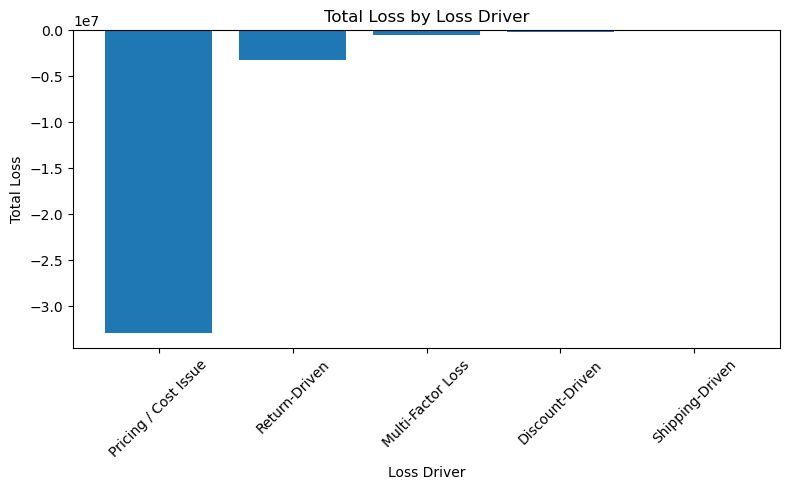

In [48]:
plt.figure(figsize=(8, 5))
plt.bar(loss_driver_impact.index, loss_driver_impact['total_loss'])
plt.title('Total Loss by Loss Driver')
plt.xlabel('Loss Driver')
plt.ylabel('Total Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# Observation

# “The chart shows total loss by driver, with values expressed in tens of millions. Pricing and cost issues dominate losses by a wide margin,
# indicating this is the primary area for corrective action.”

# conclusion

# Margin pressure is driven primarily by aggressive discounting and an unfavorable mix shift toward low-margin orders,
# rather than by revenue decline or rising product costs. While overall margins remain broadly stable, recurring dips are 
# caused by a high share of discounted and low-margin orders, with pricing and cost misalignment accounting for the largest
# absolute losses. Category-level analysis shows that margin risk is concentrated in Beauty and Home, while Electronics remains structurally
# healthy.

In [40]:
# 2. Which categories are fragile?

margin_threshold = category_fragility['avg_margin'].quantile(0.25)
loss_rate_threshold = 0.25
min_orders = 1000

category_fragility['fragility_flag'] = 'Stable'

category_fragility.loc[
    (category_fragility['avg_margin'] <= margin_threshold) &
    (category_fragility['loss_rate'] >= loss_rate_threshold) &
    (category_fragility['order_count'] >= min_orders),
    'fragility_flag'
] = 'Fragile'

category_fragility


,avg_margin,loss_rate,order_count,total_margin,fragility_flag
category,,,,,
Beauty,0.001920,0.287015,22849,5.460280e+07,Fragile
Home,1.281585,0.274311,18027,4.879063e+07,Stable
Fashion,19.188154,0.255919,17865,5.459120e+07,Stable
Electronics,23.431795,0.238037,17241,5.467724e+07,Stable


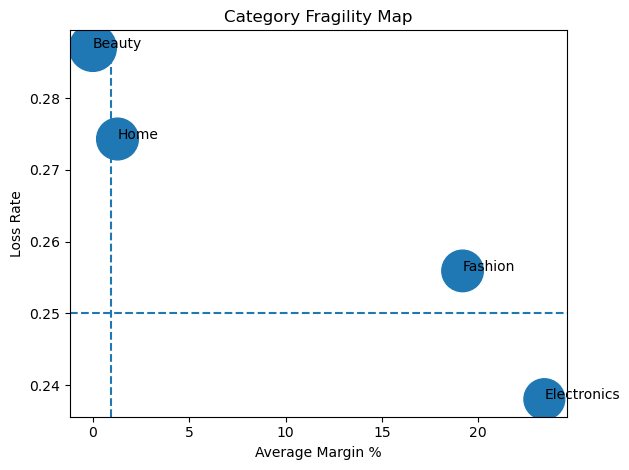

In [49]:
plt.scatter(
    category_fragility['avg_margin'],
    category_fragility['loss_rate'],
    s=category_fragility['order_count'] / 20,   # size = scale of business
)

# label each category
for x, y, label in zip(
    category_fragility['avg_margin'],
    category_fragility['loss_rate'],
    category_fragility.index
):
    plt.text(x, y, label)

plt.axhline(loss_rate_threshold, linestyle='--')
plt.axvline(margin_threshold, linestyle='--')

plt.xlabel('Average Margin %')
plt.ylabel('Loss Rate')
plt.title('Category Fragility Map')
plt.tight_layout()
plt.show()

In [36]:
# Observations

# Category fragility is concentrated in Beauty, while Home is borderline and Fashion and Electronics remain structurally healthy.

In [51]:
# 3. How does behavior differ by segment?


category_behavior = (
    df
    .groupby("category")
    .agg(
        avg_margin=("final_margin_pct", "mean"),
        loss_rate=("final_margin", lambda x: (x < 0).mean()),
        avg_discount=("discount_pct", "mean"),
        avg_shipping=("shipping_fee_allocated", "mean"),
        order_count=("order_id", "count")
    )
    .sort_values("avg_margin")
)

category_behavior


,avg_margin,loss_rate,avg_discount,avg_shipping,order_count
category,,,,,
Beauty,0.001920,0.287015,9.448919,49.914084,22849
Home,1.281585,0.274311,9.458540,50.106017,18027
Fashion,19.188154,0.255919,8.442863,50.332031,17865
Electronics,23.431795,0.238037,8.268151,50.105343,17241


In [52]:
df["discount_band"] = pd.cut(
    df["discount_pct"],
    bins=[-0.001, 0, 0.10, 0.30, 1],
    labels=["No Discount", "Low Discount", "Medium Discount", "High Discount"]
)


discount_behavior = (
    df
    .groupby("discount_band")
    .agg(
        avg_margin=("final_margin_pct", "mean"),
        loss_rate=("final_margin", lambda x: (x < 0).mean()),
        avg_shipping=("shipping_fee_allocated", "mean"),
        order_count=("order_id", "count")
    )
)

discount_behavior


C:\Users\rishi\AppData\Local\Temp\ipykernel_10564\2834188077.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("discount_band")


,avg_margin,loss_rate,avg_shipping,order_count
discount_band,,,,
No Discount,NaN,NaN,NaN,0
Low Discount,50.242758,0.084220,52.088457,1128
Medium Discount,49.442809,0.093404,47.928814,2259
High Discount,47.734043,0.094922,49.882798,7996


In [46]:
loss_driver_behavior = (
    df[df["final_margin"] < 0]
    .groupby("loss_driver")
    .agg(
        avg_loss=("final_margin", "mean"),
        total_loss=("final_margin", "sum"),
        avg_discount=("discount_pct", "mean"),
        avg_shipping=("shipping_fee_allocated", "mean"),
        order_count=("order_id", "count")
    )
    .sort_values("total_loss")
)

loss_driver_behavior


,avg_loss,total_loss,avg_discount,avg_shipping,order_count
loss_driver,,,,,
Pricing / Cost Issue,-2145.869379,-3.291334e+07,18.324804,50.358964,15338
Return-Driven,-1829.590990,-3.251183e+06,19.457554,51.158565,1777
Multi-Factor Loss,-250.401585,-5.401162e+05,12.687493,51.719508,2157
Discount-Driven,-283.027354,-2.114214e+05,50.320569,52.549108,747
Shipping-Driven,-93.615802,-1.497853e+04,2.188613,101.608927,160


In [40]:
# Observation

# -> Beauty and Home exhibit near-zero margins and the highest loss rates, despite similar discount and shipping levels as other categories, indicating structurally weak unit economics rather than extreme discounting.

# -> Fashion and Electronics maintain significantly higher margins with lower loss rates, showing better pricing discipline and more resilient profitability.

# -> As discount levels increase, average margin declines steadily and loss rates rise, confirming that discounting directly degrades margin quality, especially at high discount levels.

# -> Pricing / Cost issues dominate losses, accounting for the largest total margin leakage (~$33M), while returns are a secondary but material contributor; discount- and shipping-only losses are comparatively minor.

# -> Overall, margin pressure is driven by pricing inefficiencies and mix exposure in specific categories, amplified by high-discount behavior, rather than by shipping costs alone.



In [53]:
# Merge ab_result data with analysis

df_eda = df.merge(df_ab, on="customer_id", how="inner")



In [54]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139315 entries, 0 to 139314
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                139315 non-null  int64         
 1   product_id              139315 non-null  int64         
 2   customer_id             139315 non-null  int64         
 3   quantity                139315 non-null  int64         
 4   cost_price              139315 non-null  float64       
 5   item_price              139315 non-null  float64       
 6   discount_amount         139315 non-null  float64       
 7   discount_pct            139315 non-null  float64       
 8   shipping_fee            139315 non-null  float64       
 9   shipping_fee_allocated  139315 non-null  float64       
 10  product_revenue         139315 non-null  float64       
 11  product_cost            139315 non-null  float64       
 12  base_margin             139315

In [55]:
# Did A/b Test Work ? Let's Verify First

In [62]:
# CHECK THE BALANCE

df_eda.groupby('variant')['customer_id'].nunique()


variant
Blue_Button    6890
Control        6902
Name: customer_id, dtype: int64

In [67]:
import math

# 1. Calculate stats per group
stats = df_eda.groupby('variant')['conversion'].agg(['count', 'sum', 'mean'])
stats.columns = ['total_users', 'conversions', 'conversion_rate']

# 2. Extract values for math
cnt_n, cnt_rate = stats.loc['Control', 'total_users'], stats.loc['Control', 'conversion_rate']
var_n, var_rate = stats.loc['Blue_Button', 'total_users'], stats.loc['Blue_Button', 'conversion_rate']

# 3. Calculate Lift & Z-Score
lift = (var_rate - cnt_rate) / cnt_rate
# Standard Error formula
st_error = math.sqrt((var_rate * (1 - var_rate) / var_n) + (cnt_rate * (1 - cnt_rate) / cnt_n))
z_score = (var_rate - cnt_rate) / st_error

print(f"--- RESULTS ---")
print(f"Lift: {lift:.2%}")
print(f"Z-Score: {z_score:.2f}")

# 4. The Industry Verdict
if z_score > 1.96:
    print("Verdict: STATISTICALLY SIGNIFICANT. The Blue Button worked!")
elif z_score < -1.96:
    print("Verdict: SIGNIFICANT FAILURE. The Blue Button hurt conversions.")
else:
    print("Verdict: NOT SIGNIFICANT. The results are just noise.")

--- RESULTS ---
Lift: 0.09%
Z-Score: 0.06
Verdict: NOT SIGNIFICANT. The results are just noise.


In [47]:
# Observation 

# "The A/B test comparing the Control and Blue_Button variants resulted in a negligible lift of 0.09%. With a Z-Score of 0.06,
# the result is statistically insignificant ($p > 0.05$). We conclude that the button color change does not drive conversion
#. Recommendation: Maintain current Control design and focus on higher-impact variables like pricing or shipping fees."

In [46]:
df_eda.to_csv("eda", index=False)

In [48]:
# Final Conclusion of EDA + A/B test conclusion !!

#Margin pressure in the business is not driven by demand decline or rising product costs, but by aggressive discounting, pricing/cost misalignment, and an unfavorable mix shift toward low-margin orders.

#While overall margins appear broadly stable, recurring dips are explained by a consistently high share of discounted and low-margin orders, rather than temporary shocks. Pricing and cost issues are the dominant source of margin leakage (~$33M), with returns acting as a secondary but meaningful contributor.

#Category analysis shows that margin risk is highly concentrated, not widespread.

#Beauty is structurally fragile, with near-zero margins and the highest loss rates, indicating broken unit economics.

#Home is borderline and requires close control.

#Fashion and Electronics remain structurally healthy, with stronger margins and better pricing discipline.

#Discount analysis confirms that margin degrades steadily as discount intensity increases, and because a large share of revenue flows through high-discount orders, discounting is a material and ongoing driver of margin pressure rather than a tactical lever.

#The A/B test did not produce a statistically significant improvement in conversion or margin (negligible lift, p > 0.05). UI changes alone do not materially affect performance.

SyntaxError: invalid character '“' (U+201C) (800232672.py, line 41)

In [68]:
# Business Problem Answers

1. Should we change the discount strategy?

Yes.
Current discounting materially erodes margin quality and amplifies losses. Discount strategy requires guardrails, not expansion.

2. Which categories deserve more investment?

Electronics and Fashion.
They show healthy, scalable economics.
Beauty requires fixing, not scaling. Home should be monitored cautiously.

3. Should the A/B test be rolled out?

No.
The experiment shows no statistically reliable impact. Rollout is not justified.

4. Where is money being silently lost?

Primarily in pricing and cost misalignment, concentrated in specific categories and amplified by high-discount behavior. Returns are secondary; shipping alone is not the main driver.